In [1]:
from math import pi, cos, sin
from pprint import pprint

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.linalg as LA

import open3d as o3d
import matplotlib.pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
np.set_printoptions(suppress=True)


# 1 Rotation

In [3]:
def skew2vec(x_hat: np.ndarray) -> np.ndarray:
    """
    hat map so3 to vector
    :param x_hat:
    :return (3,) vector
    """
    assert x_hat.shape == (3, 3), "x_hat must be a 3x3 matrix"
    x1, x2, x3 = x_hat[2, 1], x_hat[0, 2], x_hat[1, 0]
    return np.array([x1, x2, x3])


def vec2skew(x: np.ndarray) -> np.ndarray:
    """
    vector to hat map so3
     [[0, -x3, x2],
      [x3, 0, -x1],
      [-x2, x1, 0]]
    :param x: vector
    :type x: numpy array vector
    :return: skew symmetric matrix
    """
    assert x.size == 3, "x must be a vector with 3 elements"
    x_hat = np.zeros((3, 3), dtype=np.float64)
    x_hat[0, 1] = -x[2]
    x_hat[0, 2] = x[1]
    x_hat[1, 0] = x[2]
    x_hat[1, 2] = -x[0]
    x_hat[2, 0] = -x[1]
    x_hat[2, 1] = x[0]

    return x_hat


def get_qs_qv_from_Quat(quat: np.ndarray):
    """Extract qs and qv from quaternion"""
    assert quat.size == 4, "q must be a quaternion with 4 elements"
    qs = quat[0]
    qv = quat[1:]
    return qs, qv


def get_rotation_matrix_from_Quat(quat: np.ndarray):
    assert quat.size == 4, "q must be a quaternion with 4 elements"
    assert abs(LA.norm(quat) - 1) < 1e-6, "q must be a unit quaternion"
    I = np.eye(3)
    qs, qv = get_qs_qv_from_Quat(quat)
    qv = qv.reshape(3, 1)

    qv_skew = vec2skew(qv)
    a = qs * I + qv_skew
    b = qs * I - qv_skew

    Eq = np.hstack([-qv, a])
    Gq = np.hstack([-qv, b])
    return Eq @ Gq.T


def get_exponential_coordinate_from_Quat(quat: np.ndarray):
    """
    return:
        omega_hat: unit vector of rotation axis
        theta: angle of rotation
    """
    qs, qv = get_qs_qv_from_Quat(quat)

    # A more numerically stable expression of the rotation angle
    # theta = 2 * np.arccos(qs)
    theta = 2 * np.arctan2(LA.norm(qv), qs)

    if theta == 0:
        return theta, np.zeros_like(qv)
    omega_hat = qv / np.sin(theta / 2)
    assert abs(LA.norm(omega_hat) - 1) < 1e-6, "||w|| != 1"

    return omega_hat, theta


def get_rotation_matrix_from_axis_angle(omega_hat: np.ndarray, theta: float):
    """
    get rotation matrix from exp map
    R ∈ SO(3) := Rot(w,theta)
        = \exp^{[\hat{w}] \theta}
        = I + [w]sin(\theta) + [w]^2 (1-cos(\theta))
    :param omega_hat: unit vector of rotation axis
    :param theta: angle of rotation
    return: rotation matrix
    """
    assert LA.norm(omega_hat) == 1, "omega_hat must be a unit vector"

    omega_hat_skew = vec2skew(omega_hat)

    # Rodrigues Formula
    rot = (
        np.eye(3)
        + omega_hat_skew * np.sin(theta)
        + LA.fractional_matrix_power(omega_hat_skew, 2) * (1 - np.cos(theta))
    )

    test = o3d.geometry.get_rotation_matrix_from_axis_angle(omega_hat * theta)
    assert np.allclose(rot, LA.expm(omega_hat_skew * theta)), "exp map is not correct"
    assert np.allclose(rot, test), "rotation matrix is not correct"
    return rot



In [4]:
class rotation:
    def __init__(self) -> None:
        sqrt2 = np.sqrt(2)
        self.p = np.array([1 / sqrt2, 1 / sqrt2, 0, 0])
        self.q = np.array([1 / sqrt2, 0, 1 / sqrt2, 0])

    def Q1(self):
        # (1) ==============================================
        r = (self.q + self.p) / 2
        norm_r = LA.norm(r)
        print(f"norm of r: {norm_r}")

        # unit quaternion
        unit_r = r / norm_r
        assert abs(LA.norm(unit_r) - 1) < 1e-6, "r is not a unit quaternion"

        rot = o3d.geometry.get_rotation_matrix_from_quaternion(unit_r)

        M_r = get_rotation_matrix_from_Quat(unit_r)
        assert np.allclose(M_r, rot), "rotation matrix is not correct"
        print(f"M(r): ")
        pprint(M_r)

        omega_hat_r, theta_r = get_exponential_coordinate_from_Quat(unit_r)
        print(f"theta: {theta_r: .4f} in radians / {np.rad2deg(theta_r)} in degrees")
        print(f"omega_hat_r: {omega_hat_r}")


    def Q2(self):
        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)

        print(f"theta_p: {theta_p: .4f} in radians / {np.rad2deg(theta_p)} in degrees")
        print(f"omega_hat_p: {omega_hat_p}")
        print(f"theta_q: {theta_q: .4f} in radians / {np.rad2deg(theta_q)} in degrees")
        print(f"omega_hat_q: {omega_hat_q}")


    def Q3_a(self):
        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)

        R_p = get_rotation_matrix_from_axis_angle(omega_hat_p, theta_p)
        R_q = get_rotation_matrix_from_axis_angle(omega_hat_q, theta_q)
        print(f"R_p: ")
        pprint(R_p)
        print(f"R_q: ")
        pprint(R_q)


    def Q3_b(self):
        _, p_qv = get_qs_qv_from_Quat(self.p)
        _, q_qv = get_qs_qv_from_Quat(self.q)

        p_skew = vec2skew(p_qv)
        q_skew = vec2skew(q_qv)

        a = LA.expm(p_skew)
        b = LA.expm(q_skew)

        c = a @ b
        d = LA.expm(p_skew + q_skew)
        print(f"exp([w1] + [w2] = ")
        print(c)
        print(f"exp([w1]) exp([w2] = ")
        print(d)

        print(f"exp([w1] + [w2]) = exp([w1]) exp([w2]): {np.allclose(c, d)}")


    def Q4_a(self):
        p_prime = -self.p
        q_prime = -self.q

        """
        Two unit quaternions correspond to the same rotation
        R(q) = R(-q)
        """

        omega_hat_p, theta_p = get_exponential_coordinate_from_Quat(self.p)
        omega_hat_q, theta_q = get_exponential_coordinate_from_Quat(self.q)
        omega_hat_p_prime, theta_p_prime = get_exponential_coordinate_from_Quat(p_prime)
        omega_hat_q_prime, theta_q_prime = get_exponential_coordinate_from_Quat(q_prime)

        print(f"theta_p: {theta_p: .4f} in radians / {np.rad2deg(theta_p)} in degrees")
        print(f"omega_hat_p: {omega_hat_p}")
        print(
            f"theta_p': {theta_p_prime: .4f} in radians / {np.rad2deg(theta_p_prime)} in degrees"
        )
        print(f"omega_hat_p': {omega_hat_p_prime}")

        print(
            f"equal rotation: {np.allclose(get_rotation_matrix_from_Quat(self.p), get_rotation_matrix_from_Quat(p_prime))}"
        )

        print("-" * 50)
        print(f"theta_q: {theta_q: .4f} in radians / {np.rad2deg(theta_q)} in degrees")
        print(f"omega_hat_q: {omega_hat_q}")
        print(
            f"theta_q': {theta_q_prime: .4f} in radians / {np.rad2deg(theta_q_prime)} in degrees"
        )
        print(f"omega_hat_q': {omega_hat_q_prime}")
        print(
            f"equal rotation: {np.allclose(get_rotation_matrix_from_Quat(self.q), get_rotation_matrix_from_Quat(q_prime))}"
        )

In [5]:
rot_ans = rotation()

## 1.1 Find a quaternion $r$ that is a scalar multiple of $(p + q)/2$ and that has unit norm, $|r| = 1$, and calculate the rotation matrix $M (r)$. Around what axis does $M (r)$ rotate, and through what angle

In [6]:
rot_ans.Q1()

norm of r: 0.8660254037844386
M(r): 
array([[ 0.66666667,  0.33333333,  0.66666667],
       [ 0.33333333,  0.66666667, -0.66666667],
       [-0.66666667,  0.66666667,  0.33333333]])
theta:  1.2310 in radians / 70.52877936550931 in degrees
omega_hat_r: [0.70710678 0.70710678 0.        ]


## 1.2 What are the exponential coordinates of $p$ and $q$?

In [7]:
rot_ans.Q2()

theta_p:  1.5708 in radians / 90.0 in degrees
omega_hat_p: [1. 0. 0.]
theta_q:  1.5708 in radians / 90.0 in degrees
omega_hat_q: [0. 1. 0.]


## 1.3.a  Build the skew-symmetric matrix $[\omega_p]$ of $p$ and $[\omega_q]$ of $q$, and derive their rotation matrices.

In [8]:
rot_ans.Q3_a()

R_p: 
array([[ 1.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  1.,  0.]])
R_q: 
array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [-1.,  0.,  0.]])


## 1.3.b your answer here

In [9]:
rot_ans.Q3_b()

exp([w1] + [w2] = 
[[ 0.7602446   0.          0.64963694]
 [ 0.42202815  0.7602446  -0.49388297]
 [-0.49388297  0.64963694  0.57797185]]
exp([w1]) exp([w2] = 
[[ 0.77015115  0.22984885  0.59500984]
 [ 0.22984885  0.77015115 -0.59500984]
 [-0.59500984  0.59500984  0.54030231]]
exp([w1] + [w2]) = exp([w1]) exp([w2]): False


## 1.3.c

In [10]:
# Note Matplotlib is only suitable for simple 3D visualization.
# For later problems, you should not use Matplotlib to do the plotting

def show_points(points):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[0], points[2], points[1])
    
def compare_points(points1, points2):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points1[0], points1[2], points1[1])
    ax.scatter(points2[0], points2[2], points2[1])    

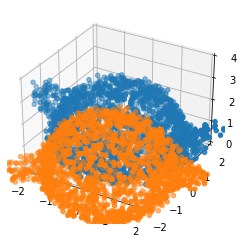

In [11]:
npz = np.load('data/HW1_P1.npz')
X = npz['X']
Y = npz['Y']
compare_points(X, Y)  # noisy teapotsand

In [12]:
# copy-paste your hw0 solve module here
def hw0_solve(A, b, eps):
    x = np.zeros(A.shape[1])
    return x

In [13]:
R1 = np.eye(3)
# solve this problem here, and store your final results in R1
for __ in range(100):
    pass

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

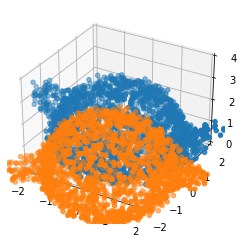

In [14]:
# Testing code, you should see the points of the 2 teapots roughly overlap
compare_points(R1@X, Y)
R1.T@R1

### 1.4.a 


In [15]:
rot_ans.Q4_a()

theta_p:  1.5708 in radians / 90.0 in degrees
omega_hat_p: [1. 0. 0.]
theta_p':  4.7124 in radians / 270.0 in degrees
omega_hat_p': [-1. -0. -0.]
equal rotation: True
--------------------------------------------------
theta_q:  1.5708 in radians / 90.0 in degrees
omega_hat_q: [0. 1. 0.]
theta_q':  4.7124 in radians / 270.0 in degrees
omega_hat_q': [-0. -1. -0.]
equal rotation: True


1.4.b your solution here

# 2 Geometry

2.1 your solution here

In [16]:
a, b, c = 1, 1, 0.5

In [17]:
# These are some convenient functions to create open3d geometries and plot them
# The viewing direction is fine-tuned for this problem, you should not change them
import open3d
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1e-4, 1))
    view_ctl.set_front((0, 0.5, 2))
    view_ctl.set_lookat((0, 0, 0))
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img)[::-1, ::-1])
    for g in geoms:
        vis.remove_geometry(g)
    
def create_arrow_from_vector(origin, vector, color = [1, 0, 1]):
    '''
    origin: origin of the arrow
    vector: direction of the arrow
    '''
    v = np.array(vector)
    v /= np.linalg.norm(v)
    z = np.array([0,0,1])
    angle = np.arccos(z@v)
    
    arrow = open3d.geometry.TriangleMesh.create_arrow(0.05, 0.1, 0.25, 0.2)
    arrow.paint_uniform_color(color)
    T = np.eye(4)
    T[:3, 3] = np.array(origin)
    T[:3,:3] = open3d.geometry.get_rotation_matrix_from_axis_angle(np.cross(z, v) * angle)
    arrow.transform(T)
    return arrow

def create_ellipsoid(a,b,c):
    sphere = open3d.geometry.TriangleMesh.create_sphere()
    sphere.transform(np.diag([a,b,c,1]))
    sphere.compute_vertex_normals()
    return sphere


def create_lines(points):
    lines = []
    for p1, p2 in zip(points[:-1], points[1:]):
        height = np.linalg.norm(p2-p1)
        center = (p1+p2) / 2
        d = p2-p1
        d /= np.linalg.norm(d)
        axis = np.cross(np.array([0,0,1]), d)
        axis /= np.linalg.norm(axis)
        angle = np.arccos(np.array([0,0,1]) @ d)
        R = open3d.geometry.get_rotation_matrix_from_axis_angle(axis * angle)
        
        T = np.eye(4)
        T[:3,:3]=R
        T[:3,3] = center
        cylinder = open3d.geometry.TriangleMesh.create_cylinder(0.02, height)
        cylinder.transform(T)
        cylinder.paint_uniform_color([1,0,0])
        lines.append(cylinder)
    return lines

In [18]:
# exapmle code to draw ellipsoid, curve, and arrows
arrow = create_arrow_from_vector([0.,0.,1.], [1.,1.,0.])
ellipsoid = create_ellipsoid(a, b, c)
cf = open3d.geometry.TriangleMesh.create_coordinate_frame()
cf.scale(1.5, (0,0,0))
curve = create_lines(np.array([[1,1,1], [-1,1,1], [-1,-1,1], [1,-1,1], [1,1,1]], dtype=np.float64))
# draw_geometries([ellipsoid, cf, arrow] + curve)
geoms = [ellipsoid, cf, arrow] + curve


In [19]:
def f(u, v):
    "map f : R2 -> R3 | (u,v) to (x,y,z)"
    assert -pi < u < pi
    assert 0 < v < pi
    return np.array([
        [a * np.cos(u) * np.sin(v)],
        [b * np.sin(u) * np.sin(v)],
        [c * np.cos(v)],
    ])


def D_fp(u, v):
    """
    differential (Jacobian)
    a linear map
    """
    a, b, c = 1, 1, 0.5
    return np.array(
        [
            [-a * np.sin(u) * np.sin(v), a * np.cos(u) * np.cos(v)],
            [b * np.cos(u) * np.sin(v), b * np.sin(u) * np.cos(v)],
            [0, -c * np.sin(v)],
        ]
    )


def gamma(t):
    """
    Parameterized Curves
    """
    u = pi / 4
    v = pi / 6
    return t + u, v


## 2.2 

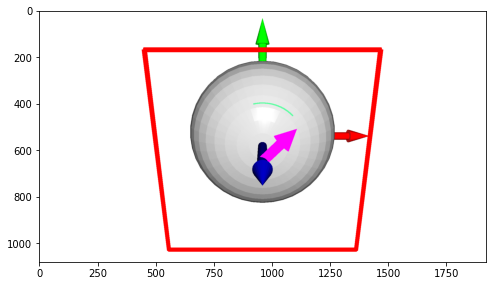

In [20]:
p = np.array([pi / 4, pi / 6])

time_steps = np.arange(0, 1, 0.01)
gamma_t = np.array([gamma(t) for t in time_steps])
                    
curve2D = np.vstack([p, gamma_t])

f_curve3D = np.asarray([f(u, v).ravel() for u, v in curve2D])

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(f_curve3D)

draw_geometries(geoms + [pcd])

### 2.3.a 
What is $Df_p$? Express it as a matrix.

In [21]:
def Df_p(u, v):
    """
    Df_p: T_p(R^2) -> T_{f(p)}R^3
    """
    a, b, c = 1, 1, 0.5
    return np.array(
        [
            [-a * np.sin(u) * np.sin(v), a * np.cos(u) * np.cos(v)],
            [b * np.cos(u) * np.sin(v), b * np.sin(u) * np.cos(v)],
            [0, -c * np.sin(v)],
        ]
    )


### 2.3.b
Describe the geometric meaning of $Df_p$

It maps or relate a vector in tangent space ($T_{p}$) of the domain $U$ to the tangent space of the surface $T_{f(p)}$.


2.3.c

In [22]:
def flatten2list(arr):
    return arr.flatten().tolist()

In [23]:
p = [pi/4, pi/6]

v = np.array([1, 0]).reshape(2, 1)

Dfp_v = D_fp(*p) @ v
Dfp_v

array([[-0.35355339],
       [ 0.35355339],
       [ 0.        ]])

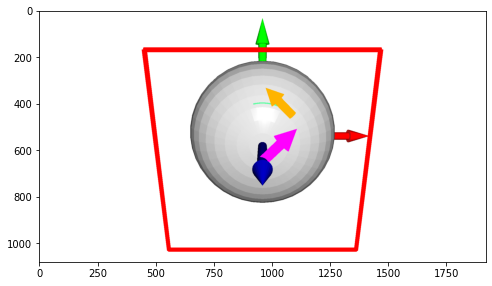

In [24]:
# start point
fp = f(*p).flatten()
Dfpv_arrow = create_arrow_from_vector(flatten2list(fp), flatten2list(Dfp_v), color=[1, 0.706, 0])
geoms_with_arrow = geoms + [Dfpv_arrow]
draw_geometries(geoms_with_arrow + [pcd])


2.3.d

2.3.e

2.4.a

2.4.b

2.4.c

2.5.a

2.5.b

2.5.c

2.5.d

# 3 Mesh

3.1 your proof here

3.2 your proof here

3.3 your solution here

In [25]:
# You may want to restart your notebook here, to reinitialize Open3D

import open3d
import numpy as np
import matplotlib.pyplot as plt

vis = open3d.visualization.Visualizer()
vis.create_window(visible = False)

# Make sure you call this function to draw the points for proper viewing direction
def draw_geometries(geoms):
    for g in geoms:
        vis.add_geometry(g)
    view_ctl = vis.get_view_control()
    view_ctl.set_up((0, 1, 0))
    view_ctl.set_front((0, 2, 1))
    view_ctl.set_lookat((0, 0, 0))
    view_ctl.set_zoom(1)
    # do not change this view point
    vis.update_renderer()
    img = vis.capture_screen_float_buffer(True)
    plt.figure(figsize=(8,6))
    plt.imshow(np.asarray(img))
    for g in geoms:
        vis.remove_geometry(g)

In [26]:
import trimesh
mesh = trimesh.load('sievert.obj')
pcd = open3d.geometry.PointCloud()
pcd.points = open3d.utility.Vector3dVector(mesh.vertices)
draw_geometries([pcd])
plt.title("Sievert's surface")

ModuleNotFoundError: No module named 'trimesh'

3.4

# 4 Point Cloud

4.1 your solution here

4.2 your solution here

4.3 your solution here

4.4 your solution here

# 5 Course Feedback